<h1><center><font size="6">Credit Card Fraud Detection Predictive Models</font></center></h1>



# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Load packages</a>  
- <a href='#3'>Read the data</a>  
- <a href='#4'>Check the data</a>  
    - <a href='#41'>Glimpse the data</a>  
    - <a href='#42'>Check missing data</a>
    - <a href='#43'>Check data unbalance</a>
- <a href='#5'>Data exploration</a>
- <a href='#6'>Predictive models</a>  
    - <a href='#61'>RandomForrestClassifier</a> 
    - <a href='#62'>AdaBoostClassifier</a>     
    - <a href='#63'>CatBoostClassifier</a> 
    - <a href='#64'>XGBoost</a> 
    - <a href='#65'>LightGBM</a> 
- <a href='#7'>Conclusions</a>
- <a href='#8'>References</a>


# <a id="1">Introduction</a>  

The datasets contains transactions made by credit cards in **September 2013** by european cardholders. This dataset presents transactions that occurred in two days, where we have **492 frauds** out of **284,807 transactions**. The dataset is **highly unbalanced**, the **positive class (frauds)** account for **0.172%** of all transactions.  

It contains only numerical input variables which are the result of a **PCA transformation**.   

Due to confidentiality issues, there are not provided the original features and more background information about the data.  

* Features **V1**, **V2**, ... **V28** are the **principal components** obtained with **PCA**;  
* The only features which have not been transformed with PCA are **Time** and **Amount**. Feature **Time** contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature **Amount** is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.   
* Feature **Class** is the response variable and it takes value **1** in case of fraud and **0** otherwise.  



In [1]:
#!pip install plotly

# <a id="2">Load packages</a>

In [2]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 42

import os

# <a id="3">Read the data</a>

In [3]:
data_df = pd.read_csv("creditcard.csv")

# <a id="4">Check the data</a>

In [4]:
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


## <a id="41">Glimpse the data</a>

We start by looking to the data features (first 5 rows).

In [5]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Let's look into more details to the data.

In [6]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Looking to the **Time** feature, we can confirm that the data contains **284,807** transactions, during 2 consecutive days (or **172792** seconds).

## <a id="42">Check missing data</a>  

Let's check if there is any missing data.

In [7]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Class,V14,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,Amount,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Time
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.

## <a id="43">Data unbalance</a>

Let's check data unbalance with respect with *target* value, i.e. **Class**.

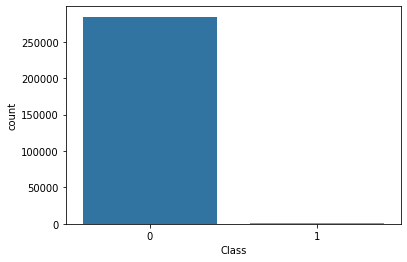

In [8]:
sns.countplot(data_df['Class'])

In [9]:
data_df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

Only **492** (or **0.172%**) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable **Class**.

# <a id="5">Data exploration</a>

## Transactions in time

In [10]:
data_df['Time']=(data_df['Time']/3600)
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]
#plt.figure(figsize = (14,4))
#plt.title('Credit Card Transactions Time Density Plot')
#sns.set_color_codes("pastel")
#sns.distplot(class_0,kde=True,bins=480)
#sns.distplot(class_1,kde=True,bins=480)
#plt.show()
hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [hr]'))
iplot(fig, filename='dist_only')

Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night in Europe timezone.

## Transactions amount

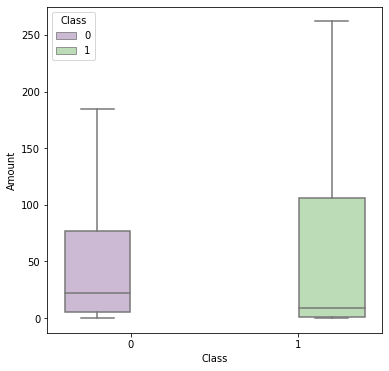

In [11]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(6,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [12]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [13]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.

Let's plot the fraudulent transactions (amount) against time. The time is shown is seconds from the start of the time period (totaly 48h, over 2 days).

In [14]:
fraud = data_df.loc[data_df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [hr]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

## Features correlation

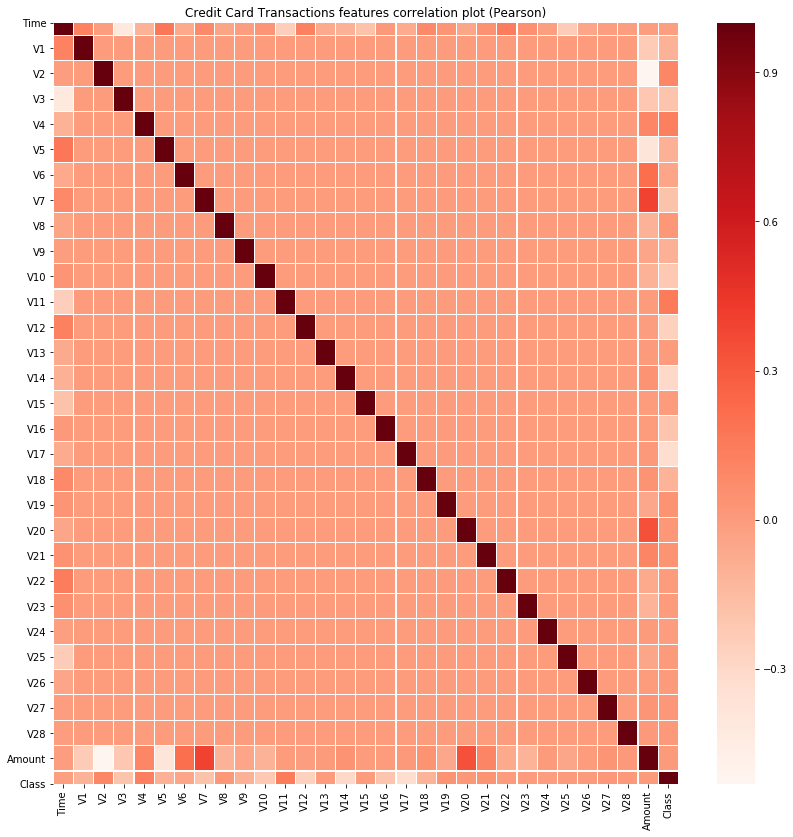

In [15]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

As expected, there is no notable correlation between features **V1**-**V28**. There are certain correlations between some of these features and **Time** (inverse correlation with **V3**) and **Amount** (direct correlation with **V7** and **V20**, inverse correlation with **V1** and **V5**).


Let's plot the correlated and inverse correlated values on the same graph.

Let's start with the direct correlated values: {V20;Amount} and {V7;Amount}.

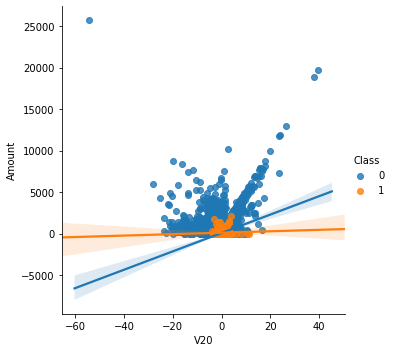

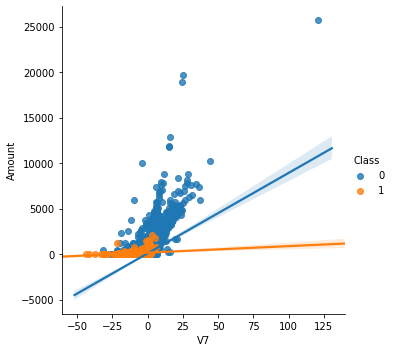

In [16]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True)
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True)
plt.show()

We can confirm that the two couples of features are correlated (the regression lines for **Class = 0** have a positive slope, whilst the regression line for **Class = 1** have a smaller positive slope).

Let's plot now the inverse correlated values.

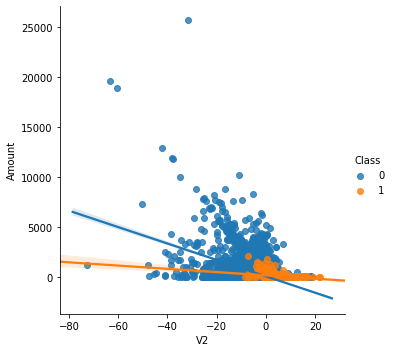

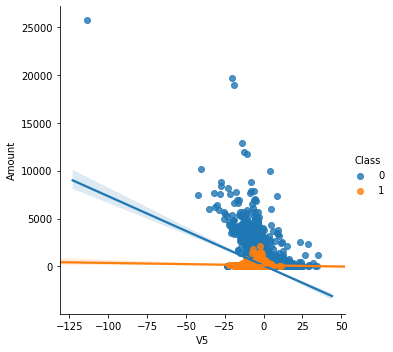

In [17]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True)
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True)
plt.show()

We can confirm that the two couples of features are inverse correlated (the regression lines for **Class = 0** have a negative slope while the regression lines for **Class = 1** have a very small negative slope).


### Linear Regression

In [18]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import Lasso,Ridge,LassoCV, RidgeCV
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [19]:
y=data_df['Class']
X=data_df.iloc[:,:-1]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3) 
lr=LinearRegression()
model1=lr.fit(X_train,y_train)

In [20]:
#Backward elimination

#cols=list(x.columns) 
cols = X.columns.tolist()
pmax=1
while len(cols)>0:
    p=[]
    x_1=X[cols]
    model=sm.OLS(y,x_1).fit()
    p=pd.Series(model.pvalues.values,index=cols)
    pmax=max(p)
    feature_max_p=p.idxmax()
    if (pmax>0.05):
        cols.remove(feature_max_p)
    else:
        break

selected_features_BE=cols
print(selected_features_BE)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [21]:
y=data_df['Class']
X=data_df[selected_features_BE]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3) 
lr=LinearRegression()
model1=lr.fit(X_train,y_train)

In [22]:
print("Coefficient b0-",model1.coef_)
print("Intercept - ",model1.intercept_)

Coefficient b0- [-1.13299978e-05 -1.83550555e-03  2.93422890e-03 -4.93557081e-03
  3.73308282e-03 -2.15045094e-03 -1.76802904e-03 -6.87063556e-03
  1.01532953e-03 -3.60599218e-03 -7.99289388e-03  6.31045367e-03
 -1.07480355e-02 -2.22396650e-04 -1.31294139e-02 -9.36152168e-03
 -1.61102174e-02 -5.67865295e-03  1.96687129e-03  1.69013233e-03
  3.32237413e-04  1.32202181e-04 -4.35424864e-04  4.65469288e-04
  3.41457597e-04  1.79523777e-03  1.45850470e-03  8.95406096e-06]
Intercept -  0.0011980884416737687


In [23]:
model=sm.OLS(y,X)
result=model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Class   R-squared (uncentered):                   0.522
Model:                            OLS   Adj. R-squared (uncentered):              0.522
Method:                 Least Squares   F-statistic:                          1.112e+04
Date:                Sat, 23 Nov 2019   Prob (F-statistic):                        0.00
Time:                        07:47:27   Log-Likelihood:                      6.0693e+05
No. Observations:              284807   AIC:                                 -1.214e+06
Df Residuals:                  284779   BIC:                                 -1.214e+06
Df Model:                          28                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [24]:
# Asumption -2 Multi colinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
pd.DataFrame({"vif":vif},index=X.columns)

,vif
Time,1.612373
V1,1.278046
V2,2.281852
V3,1.138167
V4,1.062407
V5,1.783410
V6,1.233044
V7,1.676830
V8,1.043718
V9,1.008436


# <a id="6">Predictive models</a>  



### Define predictors and target values

Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

### Logistic  regression

In [25]:
from sklearn.linear_model import LogisticRegression
mod=LogisticRegression()
mod.fit(X_train,y_train)
y_pred=mod.predict(X_test)
print('Y_predict:',y_pred)

/home/aswath/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Y_predict: [0 0 0 ... 0 0 0]


In [26]:
print('train score:',mod.score(X_train,y_train))
print('test score:',mod.score(X_test,y_test))

train score: 0.9993579583074176
test score: 0.999133925541004


In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

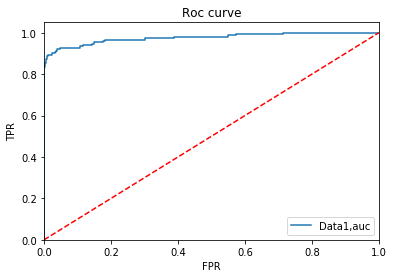

In [28]:
curve=roc_auc_score(y_test,y_pred)
fpr,tpr,threshold=roc_curve(y_test,mod.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Data1,auc' % curve)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Roc curve')
plt.legend(loc="lower right")
plt.show()

In [29]:
roc_auc_score(y_test,y_pred)

0.8144640165626583

In [30]:
accuracy_score(y_test,y_pred)

0.999133925541004

### Decision tree

In [32]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image

In [33]:
cols=X.columns
cols

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'V22',
       'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [34]:
from sklearn.tree import DecisionTreeClassifier
cl2=DecisionTreeClassifier(criterion='entropy')
cl2.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [35]:
y_predicts=cl2.predict(X_test)

In [36]:
print('Accuracy score:',accuracy_score(y_test,y_predicts))

Accuracy score: 0.9990168884519505


In [37]:
print(classification_report(y_test,y_predicts))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85292
           1       0.74      0.69      0.71       151

    accuracy                           1.00     85443
   macro avg       0.87      0.84      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [38]:
roc_auc_score(y_test,y_predicts)

0.8441539589902767

### Random forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
b=RandomForestClassifier(n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None)
b.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
y_predicts=b.predict(X_test)

In [42]:
print(classification_report(y_test,y_predicts))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85292
           1       0.92      0.73      0.81       151

    accuracy                           1.00     85443
   macro avg       0.96      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [43]:
print('Accuracy score:',accuracy_score(y_test,y_predicts))

Accuracy score: 0.9994148145547324


In [44]:
roc_auc_score(y_test,y_predicts)

0.8641856506654351

### Adaboosting Classifier

In [45]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [46]:
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.8,
                   n_estimators=100, random_state=42)

In [47]:
preds = clf.predict(X_test)

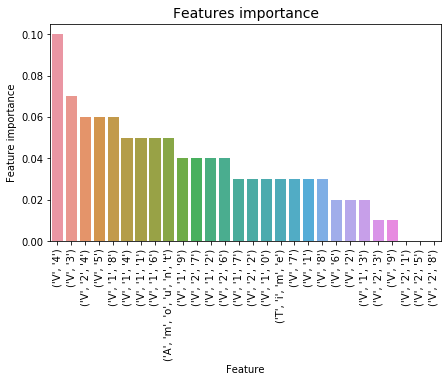

In [48]:
tmp = pd.DataFrame({'Feature': X, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

In [49]:
roc_auc_score(y_test, preds)

0.8276562897446498

In [50]:
accuracy_score(y_test, preds)

0.9990754069964772

### Gradient Boosting

In [51]:
from sklearn.ensemble import GradientBoostingClassifier
clf1 = GradientBoostingClassifier(random_state=RANDOM_STATE,
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [52]:
clf1.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.8, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [53]:
preds1 = clf1.predict(X_test)

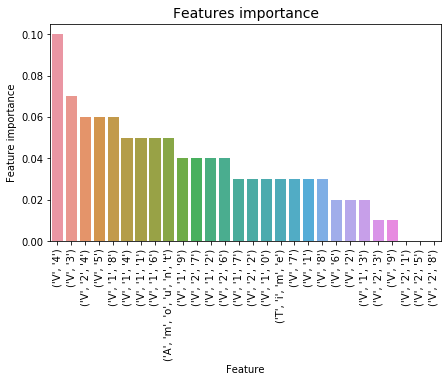

In [54]:
tmp1 = pd.DataFrame({'Feature': X, 'Feature importance': clf1.feature_importances_})
tmp1 = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

In [55]:
roc_auc_score(y_test, preds)

0.8276562897446498

In [56]:
accuracy_score(y_test, preds)

0.9990754069964772

### Clustering

In [57]:
from scipy.stats import zscore

### K-means

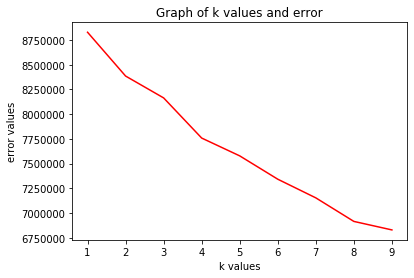

In [58]:
from sklearn.cluster import KMeans
cluster_range = range( 1, 10)
errors = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 10 )
  clusters.fit(stats.zscore(data_df))
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  errors.append( clusters.inertia_ )
    
# Visualization of k values:
plt.plot(range(1,10), errors, color='red')
plt.title('Graph of k values and error')
plt.xlabel('k values')
plt.ylabel('error values')
plt.show()

We already know that our data set has three classes. 

Bu if we didn't know how many classes we have in our data set, we sould use this method. 

And according to the graph; it's elbow (where it bends) is the best k value for our K Means algorithm

**Comparing Original Classes and K-Means Algorithm Classes:**

For visualization I will use only two features (age and duration) for the original and predicted datasets. Different classes will have seperate color and styles.

In [59]:
# Now we know our best k value is 3, I am creating a new kmeans model:
kmeans2 = KMeans(n_clusters=3)

# Training the model:
clusters = kmeans2.fit_predict(data_df)

# Adding a label feature with the predicted class values:
df_k = data_df.copy(deep=True)
df_k['label'] = clusters

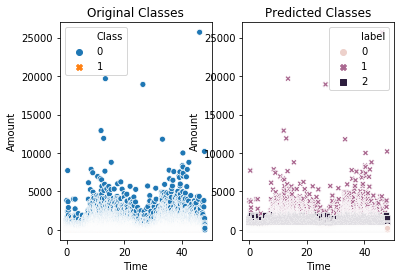

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1 = plt.subplot(1,2,1)
plt.title('Original Classes')
sns.scatterplot(y='Amount', x='Time', hue='Class', style='Class', data=data_df, ax=ax1)

ax2 = plt.subplot(1,2,2)
plt.title('Predicted Classes')
sns.scatterplot(y='Amount', x='Time', hue='label', style='label', data=df_k, ax=ax2)
plt.show()

In [61]:
print('Original Data Classes:')
print(data_df.Class.value_counts())
print('-' * 30)
print('Predicted Data Classes:')
print(df_k.label.value_counts())

Original Data Classes:
0    284315
1       492
Name: Class, dtype: int64
------------------------------
Predicted Data Classes:
0    272698
2     11493
1       616
Name: label, dtype: int64


### PCA
#### Dimensionality Reduction

In [62]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [63]:
X_std = StandardScaler().fit_transform(X)

In [64]:
# covariance matrix
cov_matrix = np.cov(X_std.T)
print('Covariance Matrix \n%s', cov_matrix)

Covariance Matrix 
%s [[ 1.00000351e+00  1.17396718e-01 -1.05933643e-02 -4.19619646e-01
  -1.05260575e-01  1.73072731e-01 -6.30166916e-02  8.47146723e-02
  -3.69495644e-02 -8.66046411e-03  3.06167361e-02 -2.47690307e-01
   1.24348505e-01 -6.59022551e-02 -9.87571660e-02  1.19029095e-02
  -7.32974707e-02  9.04384501e-02  2.89754043e-02  4.47358834e-02
   1.44059561e-01  5.11425445e-02 -1.61819253e-02 -2.33083609e-01
  -4.14072460e-02 -5.13460915e-03 -9.41272123e-03 -1.05964106e-02]
 [ 1.17396718e-01  1.00000351e+00 -4.38092261e-17 -6.25903111e-16
  -2.58664041e-16  3.09758172e-16  1.59669161e-16  1.27735329e-17
  -5.42875148e-17  5.10941315e-17  3.91189445e-17  3.27321780e-16
   1.77232769e-16 -5.21419604e-17  4.34300118e-16  3.32111855e-16
  -3.19338322e-18  1.46895628e-16  1.65257582e-16 -1.02986609e-16
   9.73981883e-17  1.85216227e-16 -5.90775896e-17 -3.32111855e-16
  -1.25739464e-16  9.12110083e-17  3.95979519e-16 -2.27709452e-01]
 [-1.05933643e-02 -4.38092261e-17  1.00000351e+00  6

In [65]:
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

In [66]:
print('Eigen Vectors \n%s', eig_vecs)
print('\n Eigen Values \n%s', eig_vals)

Eigen Vectors 
%s [[-7.06305570e-01 -3.32528666e-02  7.07119776e-01  2.88310734e-03
   7.25655445e-15 -2.23028365e-15 -1.59036968e-15 -1.92001748e-15
  -9.37623286e-16  1.64300312e-15 -3.89332783e-16  8.18525151e-16
   2.18829729e-15 -1.71531239e-15 -8.26547076e-17 -1.05103005e-15
   4.87539875e-16 -4.39212034e-16 -6.14074948e-16  3.00368425e-16
   8.98946296e-16 -5.78033300e-17  1.52180578e-16 -4.56185634e-16
  -1.51137383e-15  1.22975698e-16  8.17214704e-17 -8.24317341e-16]
 [ 1.36137621e-01 -1.75168781e-01  1.27008916e-01  1.80145880e-01
   4.00260717e-02  1.65151554e-02 -5.23215806e-02 -1.08831637e-01
   9.44370308e-03 -2.13404770e-02 -1.30177993e-01  1.27989043e-01
  -6.33197080e-02  2.02319603e-02 -5.07398705e-02  3.36342819e-01
  -1.14190386e-01 -6.58449821e-02 -2.81159258e-01 -8.34419630e-02
  -7.94496385e-03  9.64853102e-02  7.78864856e-02  2.42146203e-01
   8.06211454e-02  8.27431487e-02  2.98155944e-01  3.24210483e-01]
 [ 1.16151691e-02 -4.19354576e-01 -9.82907195e-03  4.194

In [67]:
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)

Cumulative Variance Explained [  6.77033095  12.68848895  16.25991752  19.83134609  23.40277467
  26.97420324  30.54563181  34.11706038  37.68848895  41.25991752
  44.83134609  48.40277467  51.97420324  55.54563181  59.11706038
  62.68848895  66.25991752  69.83134609  73.40277467  76.97420324
  80.54563181  84.11706038  87.68848895  91.25991752  94.83134609
  98.40277467  99.62910098 100.        ]


In [93]:
len(cum_var_exp>90)

28

Thus we can see that 95% of the variance is explained by the first 3 principal components

In [99]:
pca = PCA(n_components=5).fit_transform(X)

In [100]:
model_pca = RandomForestClassifier()
model_pca = model_pca.fit(pca, y)

/home/aswath/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



In [101]:
y_pred = model_pca.predict(pca)

In [102]:
print('Classification Report')
print(classification_report(y, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       1.00      0.88      0.94       492

    accuracy                           1.00    284807
   macro avg       1.00      0.94      0.97    284807
weighted avg       1.00      1.00      1.00    284807



In [103]:
accuracy_score(y, y_pred)

0.9997928421703118

# <a id="7">Conclusions</a>

We investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features. 

* we build a **Linear Regression**,for which we obtained the influencing factors of the target columns.

* We then investigated predictive models. The data was split into, a train set and a test set.

* We started with **Logistic Regression**, for which we obtained an ROC-AUC score of **0.82** when predicting the target for the test set,the accuracy score is **0.9992**.  

* We followed with an **Decision tree classifier** model, with criterion as **entropy** ROC-AUC score of **0.914** and the accuracy score for prediction of the test set target values is **0.9996**. 

* We followed with an **RandomForestClassifier** model, with ROC-AUC score **0.914** and the accuracy score for prediction of the test set target values is **0.9996**. 

* We followed with an **AdaBoostClassifier** model, with ROC-AUC score **0.872** and the accuracy score for prediction of the test set target values is **0.9993**. 

* We then followed with an **GradientBoostClassifier**, with ROC-AUC score **0.872** and the accuracy score for prediction of the test set target values is **0.9993**. 

* We then followed with an **K-means clustering**, with elbow method getting an K-value as **3**. 

* We then experimented with a **PCA** model. In this case, we used the training model.  The best validation score obtained was   **1.0**.


# <a id="8">References</a>

[1] Credit Card Fraud Detection Database, Anonymized credit card transactions labeled as fraudulent or genuine, https://www.kaggle.com/mlg-ulb/creditcardfraud  
[2] Principal Component Analysis, Wikipedia Page, https://en.wikipedia.org/wiki/Principal_component_analysis  
[3] RandomForrestClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
[4] ROC-AUC characteristic, https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve   
[5] AdaBoostClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html  
[6] XGBoost Python API Reference, http://xgboost.readthedocs.io/en/latest/python/python_api.html  
